# Runway Notebook

This application takes a CSV file and some optional data descriptions as input and produces the following:
- Discovery on your data
- Graph data model in json format
- Ingestion code in the following formats: 
  - PyIngest yaml file
  - load_csv cypher file
  - constraints cypher file
- Database size estimation
- Automatic data loading service if Neo4j credentials are provided

A free Neo4j Aura database can be created here: https://console.neo4j.io/

In [27]:
import os

import json
import pandas as pd
import regex as re

from summarizer.summarizer import Summarizer
from llm.llm import LLM
from ingestion.generate_ingest import IngestionGenerator
from pyingest.pyingest import PyIngest

## Gather CSV Information

In [28]:
file_name = "ppp_loan_data_demo.csv"
csv_file_dir = "data/csv/"
data = pd.read_csv(csv_file_dir+file_name)

Here are the column options

In [29]:
columns = list(data.columns)
for i in range(0, len(columns), 4):
    print(str(columns[i:i+4])[1:-1])

'Unnamed: 0.1', 'Unnamed: 0', 'LoanNumber', 'DateApproved'
'SBAOfficeCode', 'ProcessingMethod', 'BorrowerName', 'BorrowerAddress'
'BorrowerCity', 'BorrowerState', 'BorrowerZip', 'LoanStatusDate'
'LoanStatus', 'Term', 'SBAGuarantyPercentage', 'InitialApprovalAmount'
'CurrentApprovalAmount', 'UndisbursedAmount', 'FranchiseName', 'ServicingLenderLocationID'
'ServicingLenderName', 'ServicingLenderAddress', 'ServicingLenderCity', 'ServicingLenderState'
'ServicingLenderZip', 'RuralUrbanIndicator', 'HubzoneIndicator', 'LMIIndicator'
'BusinessAgeDescription', 'ProjectCity', 'ProjectCountyName', 'ProjectState'
'ProjectZip', 'CD', 'JobsReported', 'NAICSCode'
'Race', 'Ethnicity', 'UTILITIES_PROCEED', 'PAYROLL_PROCEED'
'MORTGAGE_INTEREST_PROCEED', 'RENT_PROCEED', 'REFINANCE_EIDL_PROCEED', 'HEALTH_CARE_PROCEED'
'DEBT_INTEREST_PROCEED', 'BusinessType', 'OriginatingLenderLocationID', 'OriginatingLender'
'OriginatingLenderCity', 'OriginatingLenderState', 'Gender', 'Veteran'
'NonProfit', 'ForgivenessAm

The application requires desired columns from the user. The user may optionally include a description of each desired column as well as a general description of the data. If no description is provided, then the value must be an empty string.

Column names must be an exact match to what is present in the csv file.

In [30]:
general_description = 'The data in my .csv file contains information about financial loans made to businesses.'

USER_GENERATED_INPUT = {
    'General Description': general_description,
    'BorrowerName': 'BorrowerName contains the name of the Business that applied for the loan.',
    'BusinessType': 'BusinessType contains the type of business (i.e., Corp, Partnership, LLC, etc.)',
    'LoanNumber': 'LoanNumber contains the unique identifier for the loan.',
    'CurrentApprovalAmount': 'CurrentApprovalAmount contains the financial amount of the loan.',
    'JobsReported': 'JobsReported contains the number of jobs the loan supports.',
    'ProjectState': 'ProjectState contains the state where the funds will be used.',
    'OriginatingLender': 'OriginatingLender contains the lender that originated the loan.',
    'UTILITIES_PROCEED': 'UTILITIES_PROCEED contains the amount of the loan the borrower said they will use to pay utilities.',
    'PAYROLL_PROCEED': 'PAYROLL_PROCEED contains the amount of the loan the borrower said they will use for payroll.',
    'MORTGAGE_INTEREST_PROCEED': 'MORTGAGE_INTEREST_PROCEED contains the amount of the loan the borrower said they will use to pay mortgage interest.',
    'RENT_PROCEED': 'RENT_PROCEED contains the amount of the loan the borrower said they will use to pay rent.',
    'REFINANCE_EIDL_PROCEED': 'REFINANCE_EIDL_PROCEED contains the amount of the loan the borrower said they will use to refinance an existing loan.',
    'HEALTH_CARE_PROCEED': 'HEALTH_CARE_PROCEED contains the amount of the loan the borrower said they will use to pay employee health care.',
    'DEBT_INTEREST_PROCEED': 'DEBT_INTEREST_PROCEED contains the amount of the loan the borrower said they will use to pay debt interest.'
}

## Initialize LLM & Summarizer

Provide your own OpenAI key here or alternatively set it to the environment variable OPENAI_API_KEY.

In [31]:
llm = LLM(open_ai_key=None)

In [32]:
summarizer = Summarizer(llm=llm, user_input=USER_GENERATED_INPUT, data=data)

## Discovery

In [33]:
discovery = summarizer.run_discovery()
print(discovery)

Based on the preliminary analysis of the data provided, here are some important overall details and key features:

1. **General Overview**:
   - The dataset contains information about financial loans made to businesses, with 100 entries and 14 columns.
   - There are missing values in columns like BusinessType, ProjectState, and various PROCEED columns.

2. **Key Features**:
   - **LoanNumber**: Unique identifier for each loan, providing a way to distinguish between different loans.
   - **CurrentApprovalAmount**: Financial amount of the loan, giving insight into the scale of the loans.
   - **JobsReported**: Number of jobs the loan supports, indicating the potential impact on employment.
   - **BusinessType**: Type of business, which can help in categorizing and analyzing loans based on business structures.
   - **ProjectState**: State where the funds will be used, providing geographical information.
   - **OriginatingLender**: Lender that originated the loan, which could be important

## Generate the Initial Model

We make two calls to the LLM to generate the initial model. The first call returns a model, though this first model can almost always be improved upon. We therefor call again to receive a - hopefully - better model.

recieved a valid response
recieved a valid response


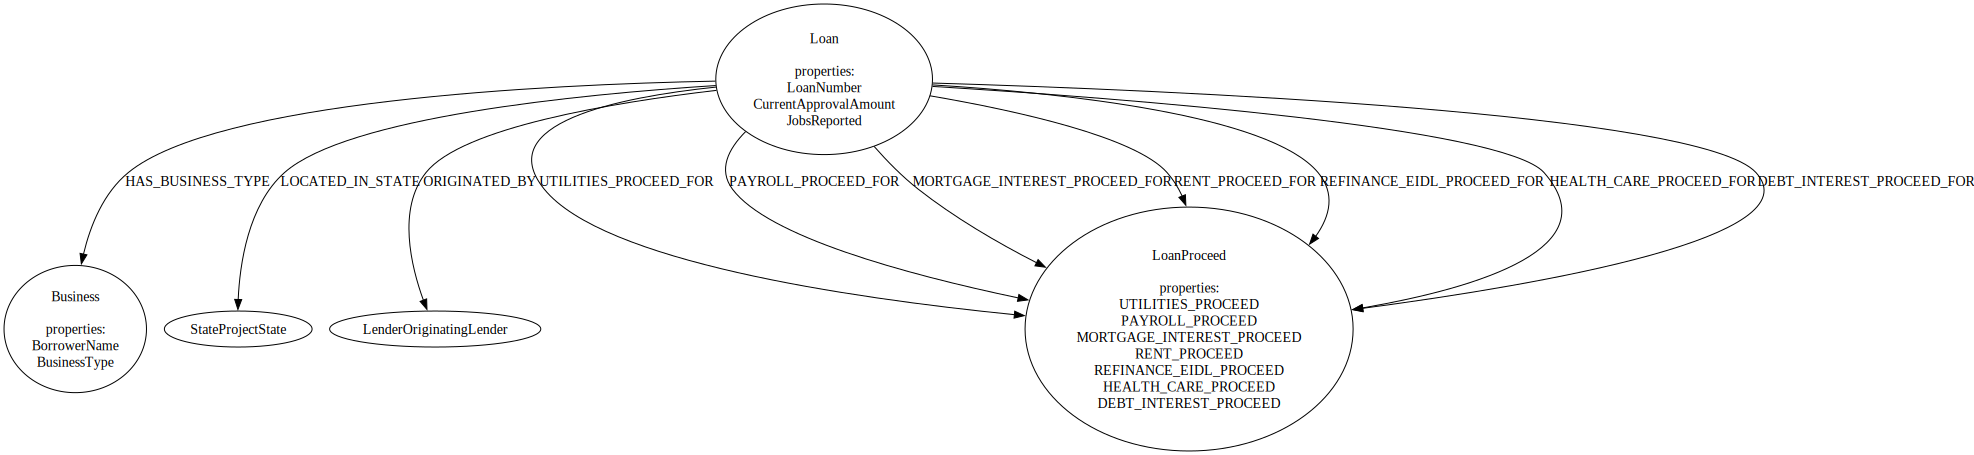

In [34]:
summarizer.create_initial_model()
summarizer.iterate_model(iterations=1)
summarizer.current_model_viz

## Iterate on the Data Model

If the user has any issues with the data model, they can be addressed here. They may enter corrections with the user_corrections variable, or run the iteration process with an empty string.

recieved a valid response


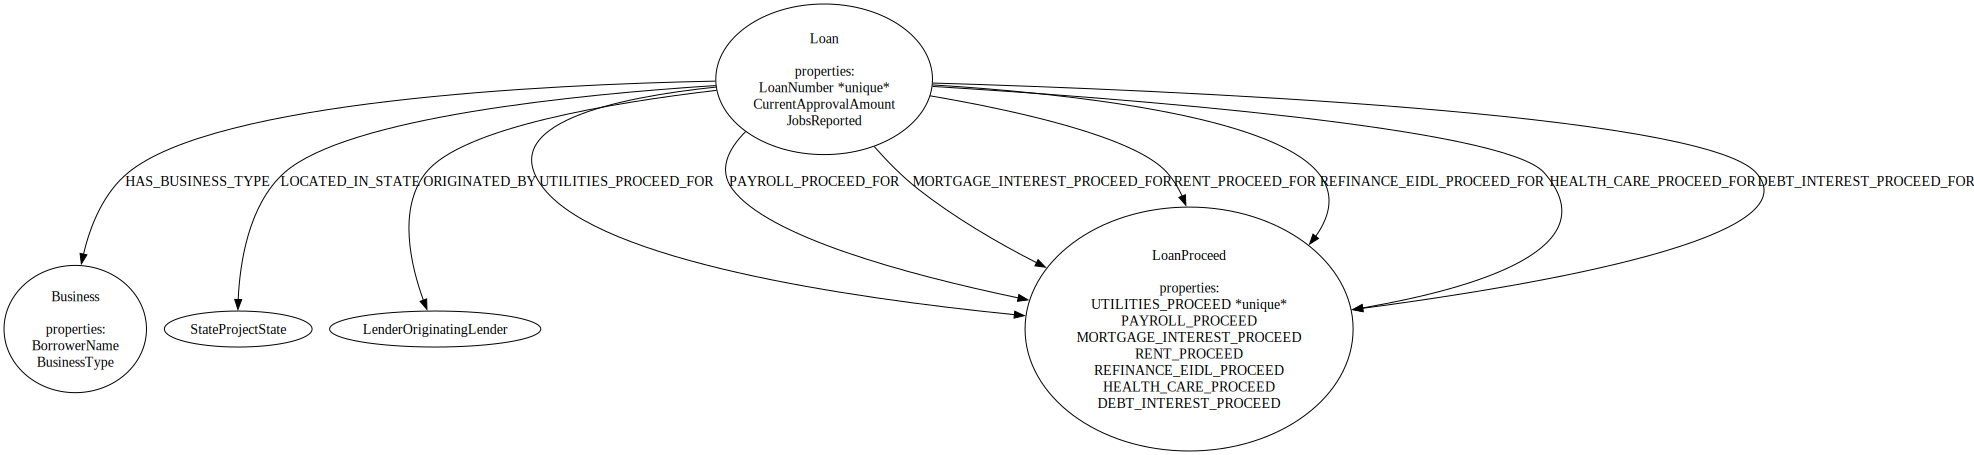

In [42]:
user_corrections = "Add a unique constraint to a property on the LoanProceed node."

summarizer.iterate_model(iterations=1, user_corrections=user_corrections)
summarizer.current_model_viz

## Neo4j Credentials

In [43]:
username = "neo4j"
password = "password"
database = "neo4j"
uri = "bolt://localhost:7687"

## Generate Ingestion Code

In [44]:
print("Number of model versions: ", len(summarizer.model_history))

Number of model versions:  4


In [45]:
model_to_use = summarizer.current_model
# if a model other than most recent is desired, then uncomment these lines and select the version number appropriately
# you can select the initial unshown model with version 0, however it is not recommended.
# model_version_to_use = 1
# model_to_use = summarizer.model_history[model_version_to_use].dict
gen = IngestionGenerator(data_model=summarizer.current_model,
                         username=username,
                         password=password,
                         database=database,
                         uri=uri,
                         csv_name=file_name,
                         csv_dir=csv_file_dir,
                         file_output_dir="test_output/")

In [46]:
gen.generate_pyingest_yaml_file()
gen.generate_load_csv_file()
gen.generate_constraints_cypher_file()

## Ingest Data into Neo4j Database

In [47]:
yaml_string = gen.generate_pyingest_yaml_string()
print(yaml_string)

server_uri: bolt://localhost:7687
admin_user: neo4j
admin_pass: password
basepath: file:./

pre_ingest:
  - CREATE CONSTRAINT loan_loannumber IF NOT EXISTS FOR (n:Loan) REQUIRE n.loannumber IS UNIQUE;
  - CREATE CONSTRAINT loanproceed_utilities_proceed IF NOT EXISTS FOR (n:LoanProceed) REQUIRE n.utilities_proceed IS UNIQUE;
files:
- chunk_size: 100
  cql: |-
    WITH $dict.rows AS rows
    UNWIND rows AS row
    MERGE (n:Loan {loannumber: row.LoanNumber})
    SET n.currentapprovalamount = row.CurrentApprovalAmount, n.jobsreported = row.JobsReported
  url: $BASE/data/csv/ppp_loan_data_demo.csv
- chunk_size: 100
  cql: |-
    WITH $dict.rows AS rows
    UNWIND rows AS row
    MERGE (n:Business {})
    SET n.businesstype = row.BusinessType, n.borrowername = row.BorrowerName
  url: $BASE/data/csv/ppp_loan_data_demo.csv
- chunk_size: 100
  cql: |-
    WITH $dict.rows AS rows
    UNWIND rows AS row
    MERGE (n:State {})
    SET n.projectstate = row.ProjectState
  url: $BASE/data/csv/ppp_loa

In [48]:
PyIngest(yaml_string=gen.generate_pyingest_yaml_string())

{} : Reading file 2024-03-01 14:34:03.555955
File {} file:.//data/csv/ppp_loan_data_demo.csv
file:.//data/csv/ppp_loan_data_demo.csv 0 2024-03-01 14:34:03.561584
{} : Completed file 2024-03-01 14:34:03.621291
{} : Reading file 2024-03-01 14:34:03.622003
File {} file:.//data/csv/ppp_loan_data_demo.csv
file:.//data/csv/ppp_loan_data_demo.csv 0 2024-03-01 14:34:03.624378
{} : Completed file 2024-03-01 14:34:03.665993
{} : Reading file 2024-03-01 14:34:03.666362
File {} file:.//data/csv/ppp_loan_data_demo.csv
file:.//data/csv/ppp_loan_data_demo.csv 0 2024-03-01 14:34:03.668132
{} : Completed file 2024-03-01 14:34:03.709837
{} : Reading file 2024-03-01 14:34:03.710138
File {} file:.//data/csv/ppp_loan_data_demo.csv
file:.//data/csv/ppp_loan_data_demo.csv 0 2024-03-01 14:34:03.712878
{} : Completed file 2024-03-01 14:34:03.776136
{} : Reading file 2024-03-01 14:34:03.776555
File {} file:.//data/csv/ppp_loan_data_demo.csv
file:.//data/csv/ppp_loan_data_demo.csv 0 2024-03-01 14:34:03.778478
{}